# Problem Set 5

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Part 2, 3 : Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#Part 4: PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
#from statsmodels.sandbox.regression.predstd import wls_prediction_std

import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.precision', 4)

# Introduction

In this assignment, you'll be analyzing movie reviews in an attempt to
determine whether movies are good or bad.  The file "reviews.csv",
contains reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh or Rotten.

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As before, we'll start out with some exploratory data analysis.

# 1 Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data, either missing review or missing fresh/rotten indicator.

#### Read 'Movies' dataset

In [2]:
movies=pd.read_table("movies.dat")
print('\nShape :', movies.shape)
print('Columns :', list(movies))
print('\nNull Values:\n------------')
movies.isnull().sum()


Shape : (9423, 21)
Columns : ['id', 'title', 'imdbID', 'spanishTitle', 'imdbPictureURL', 'year', 'rtID', 'rtAllCriticsRating', 'rtAllCriticsNumReviews', 'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore', 'rtTopCriticsRating', 'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh', 'rtTopCriticsNumRotten', 'rtTopCriticsScore', 'rtAudienceRating', 'rtAudienceNumRatings', 'rtAudienceScore', 'rtPictureURL']

Null Values:
------------


id                          0
title                       0
imdbID                      0
spanishTitle                0
imdbPictureURL            176
year                        0
rtID                      297
rtAllCriticsRating          0
rtAllCriticsNumReviews      0
rtAllCriticsNumFresh        0
rtAllCriticsNumRotten       0
rtAllCriticsScore           0
rtTopCriticsRating          0
rtTopCriticsNumReviews      0
rtTopCriticsNumFresh        0
rtTopCriticsNumRotten       0
rtTopCriticsScore           0
rtAudienceRating            0
rtAudienceNumRatings        0
rtAudienceScore             0
rtPictureURL                0
dtype: int64

#### Delete rows with non-numeric ratings 
Needed for 1.4

In [3]:
movies['rtAllCriticsRating']=movies['rtAllCriticsRating'].convert_objects(convert_numeric=True)
movies.dropna(subset = ['rtAllCriticsRating'], inplace=True)

print('\nShape (after cleanup) :', movies.shape)
print('\nNull Values (after cleanup):\n------------')
movies.isnull().sum()


Shape (after cleanup) : (9203, 21)

Null Values (after cleanup):
------------


id                          0
title                       0
imdbID                      0
spanishTitle                0
imdbPictureURL            151
year                        0
rtID                       77
rtAllCriticsRating          0
rtAllCriticsNumReviews      0
rtAllCriticsNumFresh        0
rtAllCriticsNumRotten       0
rtAllCriticsScore           0
rtTopCriticsRating          0
rtTopCriticsNumReviews      0
rtTopCriticsNumFresh        0
rtTopCriticsNumRotten       0
rtTopCriticsScore           0
rtAudienceRating            0
rtAudienceNumRatings        0
rtAudienceScore             0
rtPictureURL                0
dtype: int64

#### Preview 'Movies' dataset

In [4]:
movies.head(3)

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9.0,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...


#### Read 'Reviews' dataset

In [5]:
reviews = pd.read_csv("reviews.csv")
print('\nShape :', reviews.shape)
print('Columns :', list(reviews))
print('\nNull Values:\n------------')
reviews.isnull().sum()


Shape : (13442, 9)
Columns : ['critic', 'fresh', 'imdb', 'link', 'publication', 'quote', 'review_date', 'rtid', 'title']

Null Values:
------------


critic         705
fresh            0
imdb             0
link             0
publication      0
quote            0
review_date      0
rtid             0
title            0
dtype: int64

#### Drop rows from 'Reviews' 
0 rows dropped (Not Needed)

In [6]:
reviews.dropna(subset = ['quote','fresh'], inplace=True)

In [7]:
print(reviews.shape)
reviews.head(3)

(13442, 9)


,critic,fresh,imdb,link,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709,http://www.timeout.com/film/reviews/87745/toy-...,Time Out,"So ingenious in concept, design and execution ...",2009-10-04 00:00:00,9559,Toy Story
1,Richard Corliss,fresh,114709,"http://www.time.com/time/magazine/article/0,91...",TIME Magazine,The year's most inventive comedy.,2008-08-31 00:00:00,9559,Toy Story
2,David Ansen,fresh,114709,http://www.newsweek.com/id/104199,Newsweek,A winning animated feature that has something ...,2008-08-18 00:00:00,9559,Toy Story


## 1.1 Basic features of the dataset

Answer the following questions by having your code directly print the
answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [91]:
# enter your code below

print("Reviews dataset\n----------------------")
unique_quotes = reviews['quote'].unique() #list
print( "Unique Reviews (quotes)    :", len(unique_quotes));

unique_critics = reviews['critic'].unique() #list
print( "Unique Reviewers (critics) :", len(unique_critics));

unique_rev_movies = reviews['imdb'].unique() #list
print( "Unique Reviewed Movies     :", len(unique_rev_movies));

unique_publications = reviews['publication'].unique() #list
print( "Unique Publications        :", len(unique_publications));

print("\nMovies dataset\n----------------------")
unique_movies = movies['imdbID'].unique() #list
print( "Unique Movies              :", len(unique_movies));


Reviews dataset
----------------------
Unique Reviews (quotes)    : 12836
Unique Reviewers (critics) : 541
Unique Reviewed Movies     : 1720
Unique Publications        : 64

Movies dataset
----------------------
Unique Movies              : 9203


## 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

Does the distribution look normal?  Is it what you expect?

In [92]:
#Group reviews by reviewer
temp = reviews
temp['count'] = 1
grouped = temp['count'].groupby(temp['critic']).sum()
grouped.head(5)

critic
A.D. Murphy     14
A.H. Weiler     17
A.O. Scott      10
Aaron Hillis     2
Abel Green       5
Name: count, dtype: int64

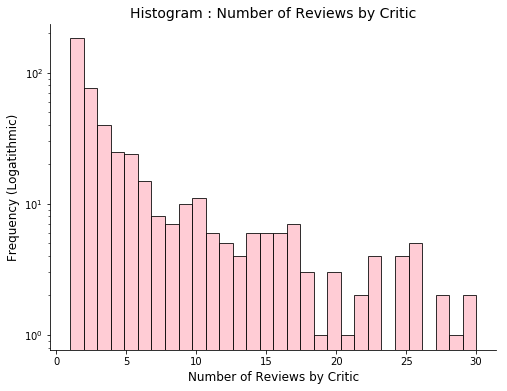

In [93]:
# Histogram - Reviews per reviewer

#Prepare the data
x = grouped[grouped.abs() <=30].values

#Prepare the plot
plt.figure(figsize=(8,6))
plt.title('Histogram : Number of Reviews by Critic', fontsize=14)
plt.xlabel('Number of Reviews by Critic', fontsize=12)
plt.ylabel('Frequency (Logatithmic)', fontsize=12)
plt.yscale('log') #Log scale on y axis
plt.grid(False)

#Plot the data
plt.hist(x, 30, alpha = 0.8, facecolor='pink', edgecolor='black')
#plt.xlim((0,30))

#Remove axes and spline
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Plot Interpretation
- _Does the distribution look normal? _

The distribution is very skewed towards the lower end, and the vast majority of critics have reviewed less than 5-10 movies.
This is not a NORMAL distribution, and seems exponential. There are only a few outliers whose reviews are in the hundreds. (Not shown in histogram)

- _Is it what you expect?_

Yes, this is expected behavior, as many real-life situations are models as power-law distributions. There is a significant exponential relationship that we can observe. Practically speaking, it is tough to review movies, and provide feedback, so it is reaasonable to see only a few long-term critics with many hundred movies reviewed as compared to the other critics who would be working on a review on a weekly/monthly basis.

## 1.3 Take a closer look of a few reviews

Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function*

In [11]:
fn_dict= {'review_date':['min','max'], 'count':['sum']}
grouped = reviews.groupby(['critic', 'publication'], as_index = True).agg(fn_dict)

#print(type(grouped)) #df
print(list(grouped)) #grouped columns

print('\nCRITICS in focus')
print(grouped.head(5))

[('review_date', 'min'), ('review_date', 'max'), ('count', 'sum')]

CRITICS in focus
                                        review_date                      count
                                                min                  max   sum
critic       publication                                                      
A.D. Murphy  Variety            2001-02-13 00:00:00  2012-02-23 00:00:00    14
A.H. Weiler  New York Times     2000-01-01 00:00:00  2006-10-31 00:00:00    17
A.O. Scott   At the Movies      2009-11-30 00:00:00  2009-11-30 00:00:00     1
             New York Times     2000-01-01 00:00:00  2008-12-05 00:00:00     9
Aaron Hillis Time Out New York  2009-12-30 00:00:00  2009-12-30 00:00:00     1


In [12]:
print('\nTOP 30 CRITICS')
sort_col_name = ('count', 'sum')
top30 = grouped.sort_values([sort_col_name],ascending=False, inplace = False)
top30.head(30)


TOP 30 CRITICS


review_date  \
                                                            min   
critic             publication                                    
Roger Ebert        Chicago Sun-Times        2000-01-01 00:00:00   
James Berardinelli ReelViews                1800-01-01 00:00:00   
Janet Maslin       New York Times           2000-01-01 00:00:00   
Variety Staff      Variety                  2001-02-13 00:00:00   
Jonathan Rosenbaum Chicago Reader           1988-07-11 00:00:00   
Desson Thomson     Washington Post          2000-01-01 00:00:00   
Geoff Andrew       Time Out                 2005-08-11 00:00:00   
Dave Kehr          Chicago Reader           2000-01-01 00:00:00   
Kenneth Turan      Los Angeles Times        2000-01-01 00:00:00   
Mick LaSalle       San Francisco Chronicle  2000-01-01 00:00:00   
Owen Gleiberman    Entertainment Weekly     1800-01-01 00:00:00   
Rita Kempley       Washington Post          2000-01-01 00:00:00   
Todd McCarthy      Variety                  2000-01-01 00:00:00   
Joe Baltake        Sacramento Bee           2000-01-01 00:00:00   
Vincent Canby      New York Times           2000-01-01 00:00:00   
Hal Hinson         Washington Post          2000-01-01 00:00:00   
Susan Stark        Detroit News             2000-01-01 00:00:00   
Stephen Holden     New York Times           2000-01-01 00:00:00   
Derek Adams        Time Out                 2006-01-26 00:00:00   
Kevin Thomas       Los Angeles Times        2000-01-01 00:00:00   
Peter Stack        San Francisco Chronicle  2000-01-01 00:00:00   
Bosley Crowther    New York Times           2000-01-01 00:00:00   
Rick Groen         Globe and Mail           2002-03-19 00:00:00   
Edward Guthmann    San Francisco Chronicle  2000-01-01 00:00:00   
Lisa Schwarzbaum   Entertainment Weekly     1979-01-01 00:00:00   
Liam Lacey         Globe and Mail           2001-08-24 00:00:00   
Emanuel Levy       Variety                  2000-01-01 00:00:00   
Richard Schickel   TIME Magazine            2007-06-27 00:00:00   
Richard Corliss    TIME Magazine            2003-12-16 00:00:00   
Jay Boyar          Orlando Sentinel         2002-01-03 00:00:00   

                                                                count  
                                                            max   sum  
critic             publication                                         
Roger Ebert        Chicago Sun-Times        2013-06-11 00:00:00  1093  
James Berardinelli ReelViews                2012-02-07 00:00:00   833  
Janet Maslin       New York Times           2010-09-07 00:00:00   526  
Variety Staff      Variety                  2012-08-15 00:00:00   450  
Jonathan Rosenbaum Chicago Reader           2013-10-22 00:00:00   420  
Desson Thomson     Washington Post          2012-10-08 00:00:00   375  
Geoff Andrew       Time Out                 2012-04-05 00:00:00   361  
Dave Kehr          Chicago Reader           2013-11-06 00:00:00   318  
Kenneth Turan      Los Angeles Times        2013-10-05 00:00:00   282  
Mick LaSalle       San Francisco Chronicle  2009-11-25 00:00:00   282  
Owen Gleiberman    Entertainment Weekly     2011-09-07 00:00:00   241  
Rita Kempley       Washington Post          2013-11-02 00:00:00   239  
Todd McCarthy      Variety                  2012-10-09 00:00:00   223  
Joe Baltake        Sacramento Bee           2004-12-22 00:00:00   221  
Vincent Canby      New York Times           2013-07-29 00:00:00   208  
Hal Hinson         Washington Post          2013-06-26 00:00:00   174  
Susan Stark        Detroit News             2002-10-25 00:00:00   167  
Stephen Holden     New York Times           2009-02-06 00:00:00   166  
Derek Adams        Time Out                 2009-10-04 00:00:00   154  
Kevin Thomas       Los Angeles Times        2013-11-02 00:00:00   145  
Peter Stack        San Francisco Chronicle  2002-06-18 00:00:00   139  
Bosley Crowther    New York Times           2008-05-06 00:00:00   138  
Rick Groen         Globe and Mail       

#### Note:
Since the records are grouped by critic and publication, the number of reviews for a critic are distributed across the various publications they work with, and do not reflect the total number of reviews the person may have written overall.


## 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

#### Drop movies with 0 or unknown ratings

In [13]:
ratings = movies[movies['rtAllCriticsRating'] > 0.0]
ratings.shape


(7752, 21)

#### Find individual and mean Movie ratings by year

In [14]:
ratings = ratings[['year', 'rtAllCriticsRating', 'title']]
print('Movie Ratings')
print(ratings.head())

Movie Ratings
   year  rtAllCriticsRating                        title
0  1995                 9.0                    Toy story
1  1995                 5.6                      Jumanji
2  1993                 5.9               Grumpy Old Men
3  1995                 5.6            Waiting to Exhale
4  1995                 5.3  Father of the Bride Part II


In [15]:
mean_ratings = ratings.groupby('year', as_index=False)['rtAllCriticsRating'].mean()
print('(Yearly) Mean Movie Ratings')
print(mean_ratings.head())

(Yearly) Mean Movie Ratings
   year  rtAllCriticsRating
0  1903              7.6000
1  1915              8.0000
2  1916              7.8000
3  1919              8.1000
4  1920              8.3667


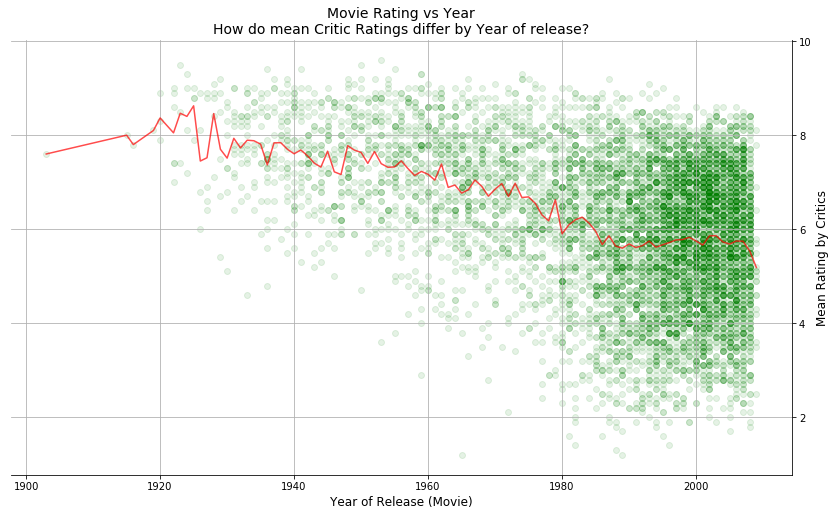

In [115]:
#Prepare the data
x = ratings['year'].values
y = ratings['rtAllCriticsRating'].values

mean_x = mean_ratings['year'].values
mean_y = mean_ratings['rtAllCriticsRating'].values

#Prepare the plot
plt.figure(figsize=(14,8))
plt.title('Movie Rating vs Year\nHow do mean Critic Ratings differ by Year of release?', fontsize=14)
plt.xlabel('Year of Release (Movie)', fontsize=12)
plt.ylabel('Mean Rating by Critics', fontsize=12)
plt.grid(False)
plt.grid()


#Plot the data
plt.scatter(x, y, alpha =0.1, c='g', label='Movie')
plt.plot(mean_x, mean_y, alpha =0.7, c='r')
#plt.legend(loc='best')

#Add y label and ticks on right side
ax = plt.gca()
ax.yaxis.tick_right()
ax.xaxis.tick_bottom()
ax.yaxis.set_label_position("right")

#Remove spines on left and top
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)


#### Plot Interpretation
- _Do you notice a trend?_

> Yes, there is a clear and visible trend in the mean ratings and the number of movies rated across the years.
1. We can see that there are a lot more movies from the recent past as compared to movies from earlier generations as denoted by the high density of green color from the 1980s to current times. 
2. Another trend is that the more recent the year considered, more the variability in the ratings as well. i.e. Movies from the earlier eras are clustered closer together in terms of ratings, whereas more recent movies have a wide variety in the ratings.
3. The mean ratings seem to dip across the decades, with movies from the 2000s barely getting ratings of 6 and some older movies averaging 8!

- _What do you think it means?_

> This graph does not prove that movies from the older times were better.
1. There are far fewer movies from the past, which suggests that the movies that have survived almost 100 years, or more than 50 years would be the ones which were universally acclaimed. Thus, the older movies in the dataset have higher mean ratings, and lower variability. 
2. Every year, there are good movies and bad movies, which is easily seen in the wide variation in the movies of the recent past.
3. Recent movies may also divided responses, since public opinion is stil being formed and engaged constantly, and majority opinion may not be settled.
4. Over deacades, the bad movies are forgotten, and only the agreed upon "good movies" tend to remain as they should be :P


____


# Part 2: Naive Bayes

Now it gets fun!  You are going to use a Naive Bayes classifier to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. 

## 2.0 Using CountVectorizer

One thing that may help you in the following problems is the _CountVectorizer_ object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in the text.  (Note: the order of words is not preserved in the bag).   Here's a simple example, make sure you understand what's going on!

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

sentences = ["Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.", "When I joined them, as usual they said go away.", "Will not.", "This yard's as much mine as it is your, Jem Finch.", "I got just as much right to play in it as you have."]
# Harper Lee "To Kill a Mockingbrid"
print ("Original text:\n", '\n'.join(sentences))

vectorizer = CountVectorizer(min_df=0)
vectorizer.fit(sentences)
# `fit` builds the vocabulary
x = vectorizer.transform(sentences).toarray()
# `transform` converts text to a bag of words
print ("Transformed text vector:\n", x)

# get_feature_names` tracks which word is associated with each column of the transformed x
print ("Words for each feature:")
print (vectorizer.get_feature_names())

Original text:
 Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.
When I joined them, as usual they said go away.
Will not.
This yard's as much mine as it is your, Jem Finch.
I got just as much right to play in it as you have.
Transformed text vector:
 [[1 0 1 0 1 1 1 1 0 1 0 0 0 2 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0
  0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0
  0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
  0]
 [0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
  1]
 [0 2 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1
  0]]
Words for each feature:
['and', 'as', 'awakened', 'away', 'back', 'conversation', 'deep', 'dill', 'finch', 'found', 'go', 'got', 'have', 'in', 'is', 'it', 'jem', 'joined', 'just', 'mine', 'morning', 'much', 'next', 'not', 'play', 'right', 'said', 'the', 'them', 'they', 'this', 'to', 'usual', 'when', '

## 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row is the bag-of-words representation for a single review.  This will be the *input* (features) of your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* (target) from your model.
 
 Make sure to remove items with no review text

Feel free to use the _make\_xy_ function below to achieve it, but you can also create your own parser.

In [208]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(critics, min_df=0, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=min_df)

    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    
    feature_names = vectorizer.get_feature_names() 
    return X, y, feature_names

In [209]:
X, y, _ = make_xy(reviews)
print('All Reviews (Vectorized)\n-------------------------')
print('\nInput Matrix = Sparse Bag of Words from Review quotes')
print('Dimensions : ', X.shape)
print(type(X))

print('\nTarget Column = Fresh(0/1) Review')
print('Length     : ', len(y))
print(type(y))


All Reviews (Vectorized)
-------------------------

Input Matrix = Sparse Bag of Words from Review quotes
Dimensions :  (13442, 20890)
<class 'scipy.sparse.csc.csc_matrix'>

Target Column = Fresh(0/1) Review
Length     :  13442
<class 'numpy.ndarray'>


## 2.2 Test-Train split

Next, randomly split the data into two groups: a training (75%) set and a validation set (25%).  You can do this manually, as you have done earlier, but I recommend to use `train_test_split` in 'sklearn.model_selection'.

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print('\nBag of words Data Type = ', type(y_train))
print('Target column Data Type= ', type(X_test))
print('Split Percent = 75-25')

print('\nTrain\n--------')
print('Bag of words Dimensions : ', X_train.shape)
print('Target Column length    : ', len(y_train))

print('\nTest\n--------')
print('Bag of words Dimensions  : ', X_test.shape)
print('Target Column length    : ',  y_test.shape)



Bag of words Data Type =  <class 'numpy.ndarray'>
Target column Data Type=  <class 'scipy.sparse.csr.csr_matrix'>
Split Percent = 75-25

Train
--------
Bag of words Dimensions :  (10081, 20890)
Target Column length    :  10081

Test
--------
Bag of words Dimensions  :  (3361, 20890)
Target Column length    :  (3361,)


## 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the `MultinomialNB` from 'sklearn'.  Play with _MultinomialNB_ parameters.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!


#### Naive Bayes

In [211]:
# enter your code here
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Evaluate Classifier 1 : Accuracy

In [212]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


print('\nTRAIN\n--------')
print('Number of test instances : ', X_train.shape[0])
preds_train = classifier.predict(X_train)  #binary predictions 0/1, not fractional
print('Correctly Classified     : ', accuracy_score(y_train, preds_train, normalize=False))
print('Accuracy of Classifer    : ', classifier.score(X_train, y_train))
print('\nConfusion Matrix:\n', confusion_matrix(y_train, preds_train))

print('\nTEST\n--------')
print('Number of test instances : ', X_test.shape[0])
preds_test = classifier.predict(X_test)  #binary predictions 0/1, not fractional
print('Correctly Classified     : ', accuracy_score(y_test, preds_test, normalize=False))
print('Accuracy of Classifer    : ', classifier.score(X_test, y_test))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, preds_test))


TRAIN
--------
Number of test instances :  10081
Correctly Classified     :  9306
Accuracy of Classifer    :  0.923122706081

Confusion Matrix:
 [[3245  564]
 [ 211 6061]]

TEST
--------
Number of test instances :  3361
Correctly Classified     :  2616
Accuracy of Classifer    :  0.778339779827

Confusion Matrix:
 [[ 774  470]
 [ 275 1842]]


#### Play with Parameters : alpha

In [213]:
train_accuracy=[]
test_accuracy=[]

for i in range(0,10):
    classifier = MultinomialNB(alpha = i)
    classifier.fit(X_train, y_train)
    
    preds_train = classifier.predict(X_train)  
    train_accuracy.append(classifier.score(X_train, y_train))
    preds_test = classifier.predict(X_test)   
    test_accuracy.append(classifier.score(X_test, y_test))

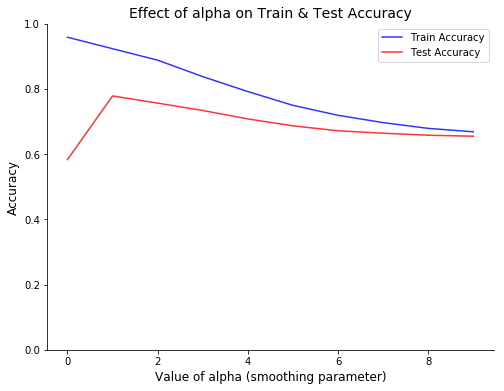

In [219]:
# Plot- Effect of Alpha
#Prepare the data
y1 = train_accuracy
y2 = test_accuracy
x = range(0,10)

#Prepare the plot
plt.figure(figsize=(8,6))
plt.title('Effect of alpha on Train & Test Accuracy', fontsize=14)
plt.xlabel('Value of alpha (smoothing parameter)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(False)

#Plot the data
plt.plot(x, y1, alpha = 0.8, color='blue',label='Train Accuracy')
plt.plot(x, y2, alpha = 0.8, color='red', label='Test Accuracy')
plt.ylim((0,1))
plt.legend(loc='best')

#Remove axes and spline
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Interpretation - Parameters, and general accuracy

- The training accuracy was 92.31% but the test accuracy was only 77.83%. for the basic model (alpha =1)
- This suggests that the model is overfitting the training data, and is not that good of an approximation for the test data.

- We can see that when alpha is 0, no smoothing is present, so test error is low, because rare words are not accounted for. With value of alpha =1, we thus see an improvement in the test error rate.
- With more and more smoothing, the overfitting is reduced and both the test and the training accuracies are pulled towards the center of the plot.

## 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!

That was almost too easy, right?  Right.

Your next mission, if you feel you want to take an extra challenge, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:** Do this *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [238]:
#Self-defined function :)
# Currently only works in the order : fit -> predict_proba -> predict
class BinaryNB:
    
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.n=0
        self.p=0
        self.log_prob1 = 0
        self.log_prob2 = 0    
        self.log_prob_words_1 =0
        self.log_prob_words_2 =0
    
    
    def validate(self, X,y):
        if(X.shape[0] != len(y)):
            print('Validation Error!')
        return False;   

    def fit(self, X , y):
        #Find Class Probabilities
        #self.validate(X,y)
        self.n  = len(y)
        n1 = len(y[y==0])
        n2 = len(y[y==1])
        
        prob1 = (n1 + self.alpha)/(self.n*2)
        prob2 = (n2 + self.alpha)/(self.n*2)
                                   
        self.log_prob1 = np.log(prob1)
        self.log_prob2 = np.log(prob2)
        
        #Find number of words (vocabulary)
        self.p = X.shape[1] #shape[0] should be same as n
        
        #Divide Data into True Positives, True Negatives
        z= np.c_[y, X]
        set1 = z[z[:,0] == 0]  #True y =0        
        set2 = z[z[:,0] == 1]  #True y =1
        
        #Find (word) counts per class
        total_words = np.sum(X, axis=0)
        
        #Find (word) feature conditional probabilities
        words_1 = np.sum(set1[:,1:], axis=0)
        words_2 = np.sum(set2[:,1:], axis=0)
        all_words = np.sum(X, axis=0)
        
        prob_words_1 = np.divide(words_1, all_words)
        prob_words_2 = np.divide(words_2, all_words)
        
        self.log_prob_words_1 = np.log(prob_words_1)
        self.log_prob_words_2 = np.log(prob_words_2)

    def predict_proba(self, X):
        self.mle1 = self.log_prob1 + np.sum(X*self.log_prob_words_1, axis=1)
        self.mle2 = self.log_prob2 + np.sum(X*self.log_prob_words_2, axis=1)
        print(self.mle1, self.mle2)
        return (self.mle1, self.mle2) 

    def predict(self, X):
        predictions = np.zeros(self.n)        
        print(predictions)
        predictions = np.where(self.mle1 > self.mle2 , 0, 1)
        print(predictions)
        return predictions    
    
    def score(X):
        return 0


____

# 3 Evaluation

## 3.1 Estimate the likelihood of your data

Calculate log-likelihood of a fitted model.  Log-likelihood is a way to assess the performance of your model.  Remeber -- likelihood is more-or-less the probability to observe your data (including your target).  Below is an example function that calculates the log-likelihood of an estimated model using `fitted_model.predict_logproba`.  You may use this function, or write your own.  

#### Define : Function to estimate log-likelihood for a classifier model

In [24]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 

The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews.

Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    # returns Nx2 array.  Columns are log(Pr(y == 0|x)), log(Pr(y==1|x))
    ll = prob[y == 0, 0].sum() + prob[y == 1, 1].sum()
    return ll

#### Evaluate: Log-Likelihood function

In [25]:
print('Train Log Likelihood :', log_likelihood(classifier, X_train, y_train))
print('Test  Log Likelihood :', log_likelihood(classifier, X_test, y_test))

Train Log Likelihood : -1942.92896336
Test  Log Likelihood : -1864.05542662


In [26]:
from sklearn.metrics import log_loss
pred_probs_train = classifier.predict_proba(X_train)
pred_probs_test = classifier.predict_proba(X_test)

#If normalize, returns mean loss per sample. Else, sum of per-sample losses
print('Train Log Loss :', log_loss(y_train, pred_probs_train, normalize=False))
print('Test  Log Loss :', log_loss(y_test, pred_probs_test, normalize=False))

Train Log Loss : 1942.92896336
Test  Log Loss : 1864.05542662


## 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.
Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The `alpha` keyword in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

We are going to use cross-validation to tune these hyperparameters.  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.model_selection.cross_val_score`, that might save you a lot of time here...*

#### Define: Grid search the parameter space to  optimize Naive Bayes classifier 
Default optimization-> Maximize Log-Likelihood

In [27]:
from sklearn.model_selection import cross_val_score

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
params = {'alpha' : alphas , 'min_df' : min_dfs}


def grid_search_NB(alphas=[0], min_dfs=[0], num_splits=3, score_fn=log_likelihood):

    print('NAIVE BAYES - Grid Search in parameter space\n---------------------------------------------')
    print('Min_dfs (Threshold)          :', min_dfs)
    print('Alphas (Smoothing Parameter) :', alphas)
    print('\nNumber of CV Splits :', num_splits)
    print('Scoring Function    :', score_fn)
    print('\n')

    #1st row= colnames , #1st col= index
    grid_arr =np.array(['', 'min_df', 'alpha' , 'Mean Score'], dtype=object)

    i=0
    for alpha in alphas:
        for min_df in min_dfs:
            #print('Iteration :', i)
            i+=1     
            X, y, _ = make_xy(reviews, min_df = min_df)
            clf = MultinomialNB(alpha = alpha)
            ll_score = np.mean(cross_val_score(clf, X, y, scoring=score_fn, cv=num_splits))
            row = np.array([i, min_df, alpha, ll_score], dtype=object)
            grid_arr = np.vstack((grid_arr, row))

    grid_df = pd.DataFrame(data=grid_arr[1:,1:], columns =grid_arr[0,1:], index=grid_arr[1:,0])    
    return grid_df

#### Naive Bayes - Find best min_df, alpha for max Log likelihood

In [28]:
grid_df= grid_search_NB(alphas, min_dfs, num_splits=3, score_fn=log_likelihood)
print(grid_df)

NAIVE BAYES - Grid Search in parameter space
---------------------------------------------
Min_dfs (Threshold)          : [1e-05, 0.0001, 0.001, 0.01, 0.1]
Alphas (Smoothing Parameter) : [0, 0.1, 1, 5, 10, 50]

Number of CV Splits : 3
Scoring Function    : <function log_likelihood at 0x00000227A2E7F378>


    min_df alpha Mean Score
1    1e-05     0        NaN
2   0.0001     0        NaN
3    0.001     0        NaN
4     0.01     0      -2814
5      0.1     0      -2916
6    1e-05   0.1      -3944
7   0.0001   0.1      -3942
8    0.001   0.1      -2795
9     0.01   0.1      -2814
10     0.1   0.1      -2916
11   1e-05     1      -2695
12  0.0001     1      -2646
13   0.001     1      -2618
14    0.01     1      -2811
15     0.1     1      -2916
16   1e-05     5      -4554
17  0.0001     5      -3270
18   0.001     5      -2489
19    0.01     5      -2803
20     0.1     5      -2915
21   1e-05    10      -6183
22  0.0001    10      -4660
23   0.001    10      -2540
24    0.01    10     

In [29]:
#Find index of highest log-likelihood (smallest negative number)
print('Log_Likelihood\n-----------------')
idx = grid_df['Mean Score'].idxmax()
print('Highest Log Likelihood at Index :', idx)

print('\nBest Parameters (min_df, alpha) :')
grid_df.ix[idx]

Log_Likelihood
-----------------
Highest Log Likelihood at Index : 18

Best Parameters (min_df, alpha) :


min_df        0.001
alpha             5
Mean Score    -2489
Name: 18, dtype: object

#### Optimal Parameters for Max Log-Likelihood
The optimal parameters that maximize log likelihood have values as stated above.
- Min_df (Threshold) = 0.001
- Alpha (Smoothing) = 5

## 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [87]:
#For MAX log_likelihood
best_min_df = 0.001
best_alpha  = 5

In [88]:
#Featurize text into X, y (using best min_df for threshold)
X, y, _ = make_xy(reviews, min_df = best_min_df)

#Create Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#Fit the classifier on Train data (using best alpha for smoothing)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Evaluate Classifier 2 : Accuracy  (Optimized for max log-likelihood)

In [32]:
print('\nTRAIN\n--------')
print('Number of test instances : ', X_train.shape[0])
preds_train = classifier.predict(X_train)  #binary predictions 0/1, not fractional
print('Correctly Classified     : ', accuracy_score(y_train, preds_train, normalize=False))
print('Accuracy of Classifer    : ', classifier.score(X_train, y_train))
print('\nConfusion Matrix:\n', confusion_matrix(y_train, preds_train))

print('\nTEST\n--------')
print('Number of test instances : ', X_test.shape[0])
preds_test = classifier.predict(X_test)  #binary predictions 0/1, not fractional
print('Correctly Classified     : ', accuracy_score(y_test, preds_test, normalize=False))
print('Accuracy of Classifer    : ', classifier.score(X_test, y_test))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, preds_test))


TRAIN
--------
Number of test instances :  10081
Correctly Classified     :  8085
Accuracy of Classifer    :  0.802003769467

Confusion Matrix:
 [[2740 1069]
 [ 927 5345]]

TEST
--------
Number of test instances :  3361
Correctly Classified     :  2516
Accuracy of Classifer    :  0.74858673014

Confusion Matrix:
 [[ 778  466]
 [ 379 1738]]


#### Effect of Cross Validation
- By doing cross-validation, we get a more robust estimation of error.
- We can be surer of our estimated accuracies, as we take the average estimated values across the splits.

#### Evaluating Model Accuracy
- By using the smoothing parameter and thresholds that maximize likelihood, we have generalizability, and have a worse accuracy metric. 
- The newer model is less accurate, and does worse on both the train and test data.
- The possible reason for this worse performance, is that the data is optimized for the maximum log likelihood, which is not the same as the accuracy metric of classification error, and the data can be optimizing for the wrong metric.
- We have a much worse model, and clearly we shouldn't use this model since test error is much lower.
- The training accuracy has fallen down from 92% to 80% and test accuracy has fallen from 77% to 74%

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

#### Naive Bayes - Find best min_df, alpha for  highest Accuracy

In [33]:
#Search parameter space with Accuracy Metric
grid_df= grid_search_NB(alphas, min_dfs, num_splits=3, score_fn='accuracy')
print(grid_df)

NAIVE BAYES - Grid Search in parameter space
---------------------------------------------
Min_dfs (Threshold)          : [1e-05, 0.0001, 0.001, 0.01, 0.1]
Alphas (Smoothing Parameter) : [0, 0.1, 1, 5, 10, 50]

Number of CV Splits : 3
Scoring Function    : accuracy


    min_df alpha Mean Score
1    1e-05     0     0.5495
2   0.0001     0     0.6002
3    0.001     0     0.7336
4     0.01     0     0.6617
5      0.1     0     0.6257
6    1e-05   0.1     0.7384
7   0.0001   0.1     0.7378
8    0.001   0.1      0.736
9     0.01   0.1     0.6617
10     0.1   0.1     0.6257
11   1e-05     1     0.7603
12  0.0001     1     0.7596
13   0.001     1      0.737
14    0.01     1     0.6615
15     0.1     1     0.6257
16   1e-05     5     0.6692
17  0.0001     5     0.7093
18   0.001     5     0.7311
19    0.01     5     0.6596
20     0.1     5     0.6256
21   1e-05    10     0.6384
22  0.0001    10     0.6541
23   0.001    10     0.7212
24    0.01    10      0.659
25     0.1    10     0.6255
26  

In [34]:
#Find index of highest log-likelihood (smallest negative number)
print('Accuracy\n---------')
idx = grid_df['Mean Score'].idxmax()
print('Highest Accuracy at Index :', idx)

print('\nBest Parameters (min_df, alpha) :')
grid_df.ix[idx]

Accuracy
---------
Highest Accuracy at Index : 11

Best Parameters (min_df, alpha) :


min_df         1e-05
alpha              1
Mean Score    0.7603
Name: 11, dtype: object

#### Optimal parameters for  maximum Naive Bayes Accuracy
The best values of smoothing parameter and threshold for increasing the accuracy have been calculated as 1, and 1e-05 respectively.

In [35]:
#For MAX Accuracy
best_min_df = 1e-05
best_alpha  = 1

In [36]:
#Featurize text into X, y (using best min_df for threshold)
X, y, _ = make_xy(reviews, min_df = best_min_df)

#Create Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#Fit the classifier on Train data (using best alpha for smoothing)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Evaluate Classifier 3 : Accuracy  (Optimized for Classification Error)

In [37]:
print('\nTRAIN\n--------')
print('Number of test instances : ', X_train.shape[0])
preds_train = classifier.predict(X_train)  #binary predictions 0/1, not fractional
print('Correctly Classified     : ', accuracy_score(y_train, preds_train, normalize=False))
print('Accuracy of Classifer    : ', classifier.score(X_train, y_train))
print('\nConfusion Matrix:\n', confusion_matrix(y_train, preds_train))

print('\nTEST\n--------')
print('Number of test instances : ', X_test.shape[0])
preds_test = classifier.predict(X_test)  #binary predictions 0/1, not fractional
print('Correctly Classified     : ', accuracy_score(y_test, preds_test, normalize=False))
print('Accuracy of Classifer    : ', classifier.score(X_test, y_test))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, preds_test))


TRAIN
--------
Number of test instances :  10081
Correctly Classified     :  9306
Accuracy of Classifer    :  0.923122706081

Confusion Matrix:
 [[3245  564]
 [ 211 6061]]

TEST
--------
Number of test instances :  3361
Correctly Classified     :  2616
Accuracy of Classifer    :  0.778339779827

Confusion Matrix:
 [[ 774  470]
 [ 275 1842]]


#### Interpretation: Effect of optimizing for Accuracy
By optimizing the min_df and alpha for accuracy, we have create a better classifier than before, which performs better on both the training and test data. This is a more generalizable classifier than the previous models. This is seen by the increased accuracy in the test and training sets. We expect the training error to be better than test error usually.

## 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

#### Logic: Which words best predict a fresh/rotten review
- Let's use all the reviews to train our model, and get the vectorizer's features.
- Then, the test data can be an identity matrix, meaning a sentence that contains only one word from the feature set. 
- The predicted fresh/rotten score will give the individual impact of a word on "freshness".

#### Fit NB Classifier : ALL data, with threshold and smoothing

In [38]:
#Featurize entire text into X, y
X, y, feature_names = make_xy(reviews, min_df=1e-05)

#Fit the classifier on ALL reviews
classifier = MultinomialNB(alpha=1)
classifier.fit(X, y)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

#### Test Identity Matrix with fitted Naive Bayes Classifier

In [77]:
num_features = len(feature_names)
print('Number of features (words) = ', num_features)

#Create Identity matrix for testing
single_words = np.identity(num_features)

#Classify Test data
word_preds = classifier.predict(single_words)

#Calculate word probabilstic predictions for all candidate classes
word_proba = classifier.predict_proba(single_words)
print('\nProbabilistic Predictions')
print(word_proba.shape)
print(word_proba)

#Test word probabilities for predicted classes (Maximum Likelihood)
print('\nPrediction Confidence')
word_pred_prob = np.maximum(word_proba[:,0] ,  word_proba[:,1]) #Compare probs between Classes 1, 2
print(word_pred_prob.shape)
print(word_pred_prob)

Number of features (words) =  20890

Probabilistic Predictions
(20890, 2)
[[ 0.60973026  0.39026974]
 [ 0.31912534  0.68087466]
 [ 0.23807554  0.76192446]
 ..., 
 [ 0.65214928  0.34785072]
 [ 0.38458969  0.61541031]
 [ 0.65214928  0.34785072]]

Prediction Confidence
(20890,)
[ 0.60973026  0.68087466  0.76192446 ...,  0.65214928  0.61541031
  0.65214928]


In [78]:
data_dict = {'Test Word': feature_names, 
             'Fresh Prediction (0/1)' : word_preds , 
             'Confidence'       : word_pred_prob , 
             'Rotten Prob'   : word_proba[:,0], 
             'Fresh Prob'    : word_proba[:,1]  }

df = pd.DataFrame(data_dict, columns = ['Test Word', 'Fresh Prediction (0/1)', 'Confidence', 'Rotten Prob', 'Fresh Prob'])
print('Predictions for Individual Words\n', df.head())

Predictions for Individual Words
   Test Word  Fresh Prediction (0/1)  Confidence  Rotten Prob  Fresh Prob
0       000                       0      0.6097       0.6097      0.3903
1      0014                       1      0.6809       0.3191      0.6809
2       007                       1      0.7619       0.2381      0.7619
3       044                       0      0.6521       0.6521      0.3479
4        07                       1      0.6809       0.3191      0.6809


#### Which words best predict Fresh / Rotten reviews?

In [80]:
print('10 Predictive Words for FRESH Rating')
df.sort_values(by='Fresh Prob', ascending= False).head(10)

10 Predictive Words for FRESH Rating


,Test Word,Fresh Prediction (0/1),Confidence,Rotten Prob,Fresh Prob
4755,delight,1,0.9787,0.0213,0.9787
9712,intimate,1,0.9664,0.0336,0.9664
2742,captures,1,0.9639,0.0361,0.9639
3118,childhood,1,0.9608,0.0392,0.9608
12183,myth,1,0.9608,0.0392,0.9608
15667,rousing,1,0.9591,0.0409,0.9591
16150,seductive,1,0.9573,0.0427,0.9573
19551,unforgettable,1,0.9552,0.0448,0.9552
6462,expertly,1,0.9552,0.0448,0.9552
1242,astonishing,1,0.9530,0.0470,0.9530


In [42]:
print('10 Predictive Words for ROTTEN Rating')
df.sort_values(by='Rotten Prob', ascending= False).head(10)

10 Predictive Words for ROTTEN Rating


,Test Word,Fresh Prediction (0/1),Confidence,Rotten Prob,Fresh Prob
10378,lame,0,0.9620,0.9620,0.0380
13786,pointless,0,0.9606,0.9606,0.0394
19558,unfortunately,0,0.9538,0.9538,0.0462
19589,uninspired,0,0.9538,0.9538,0.0462
18806,tiresome,0,0.9410,0.9410,0.0590
15762,sadly,0,0.9410,0.9410,0.0590
5137,disappointingly,0,0.9292,0.9292,0.0708
16888,sluggish,0,0.9242,0.9242,0.0758
18502,tepid,0,0.9242,0.9242,0.0758
20598,witless,0,0.9242,0.9242,0.0758


#### Explanation

#### a) Top 10 Fresh Words
These words seem to be reasonable, and we would expect a reviewer to use words like 'captures', 'expertly', 'masterpiece' etc in good movies.

#### b) Top 10 Rotten Words
The words in this list do not need an explanation, as they signify dullness of a movie. E.g. lame, pointless, uninspired, sadly, all show the disappointment of a critic in this movie.

####  c) What happens when a word appears only once?
When a word occurs in only one class (e.g. Class 1), the simple Naive Bayes Classifier will predict the same class (Class 1) with a 100% confidence, since it has only seen it in one instance of the word.

When we use add-one smoothing, as in this case (since alpha =1), we are better prepared to deal with rare words. In this case, the classifier sort of pretends to have a record of all words once in each class. Thus, the counts of the single-occurrence word will be 2 in the class 1, and 1 in the other. 

The predicted probability confidence will be 2/3.

___

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

#### Fit NB Model : All data, classifier optimized for accuracy

In [94]:
#Featurize text into X, y (using best min_df for threshold)
vectorizer = CountVectorizer(min_df=1e-05)
X = vectorizer.fit_transform(reviews.quote)
X = X.tocsc()  # some versions of sklearn return COO format
y = (reviews.fresh == 'fresh').values.astype(np.int)

feature_names = vectorizer.get_feature_names() 

#Fit the classifier on Train data (using best alpha for smoothing)
classifier = MultinomialNB(alpha=1)
classifier.fit(X, y)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [95]:
num_features = len(feature_names)
print('Number of features (words) = ', num_features)

#Calculate word probabilities for all candidate classes
preds_proba = classifier.predict_proba(X)
#Test word probabilities for predicted classes (Maximum Likelihood)
predicted_prob = np.maximum(preds_proba[:,0], preds_proba[:,1]) #Compare probs between Classes 1, 2


Number of features (words) =  20890


In [96]:
reviews['is_fresh'] = np.where(reviews['fresh']=='fresh', 1,0)
data_dict = {'Movie': reviews['title'].values, 
             'Quote': reviews['quote'].values, 
             'Actual Fresh (0/1)'   : reviews['is_fresh'].values , 
             'Predict Fresh (0/1)'   : classifier.predict(X) , 
             'Confidence': predicted_prob , 
             'Rotten Prob'   : preds_proba[:,0], 
             'Fresh Prob'    : preds_proba[:,1]  }

df = pd.DataFrame(data_dict, columns = ['Movie', 'Quote', 'Actual Fresh (0/1)', 'Predict Fresh (0/1)',  'Rotten Prob', 'Fresh Prob'])
df.head()

,Movie,Quote,Actual Fresh (0/1),Predict Fresh (0/1),Rotten Prob,Fresh Prob
0,Toy Story,"So ingenious in concept, design and execution ...",1,1,0.0035,0.9965
1,Toy Story,The year's most inventive comedy.,1,1,0.0870,0.9130
2,Toy Story,A winning animated feature that has something ...,1,1,0.0066,0.9934
3,Toy Story,The film sports a provocative and appealing st...,1,1,0.0007,0.9993
4,Toy Story,"An entertaining computer-generated, hyperreali...",1,1,0.0010,0.9990


In [98]:
truly_fresh= df['Actual Fresh (0/1)']==1
said_fresh = df['Predict Fresh (0/1)']==1

#Poor predictions on FRESH reviews
print('\nPoor Predictions on FRESH Reviews')
poor_fresh_preds = df[truly_fresh & ~said_fresh].sort_values(by='Rotten Prob', ascending=False)
poor_fresh_preds.head()


Poor Predictions on FRESH Reviews


,Movie,Quote,Actual Fresh (0/1),Predict Fresh (0/1),Rotten Prob,Fresh Prob
5400,Young Frankenstein,"Some of the gags don't work, but fewer than in...",1,0,0.9981,0.0019
8621,Charlotte's Web,There's too much talent and too strong a story...,1,0,0.9967,0.0033
1715,The Mask,The gangland plot is flimsy (bad guy Peter Gre...,1,0,0.9905,0.0095
6357,Broken English,The fence-straddling would be fatal if it were...,1,0,0.9903,0.0097
11352,Monty Python's And Now for Something Completel...,A kind of insane logic seems to connect the sk...,1,0,0.9897,0.0103


In [99]:
#Poor predictions on ROTTEN reviews
print('\nPoor Predictions on ROTTEN Reviews')
poor_rotten_preds = df[~truly_fresh & said_fresh].sort_values(by='Fresh Prob', ascending=False)
poor_rotten_preds.head()


Poor Predictions on ROTTEN Reviews


,Movie,Quote,Actual Fresh (0/1),Predict Fresh (0/1),Rotten Prob,Fresh Prob
9463,The Waterboy,The Waterboy is arguably Sandler's most enjoya...,0,1,0.0010,0.9990
6293,Grosse Pointe Blank,"It's a sad day when an actor who's totally, be...",0,1,0.0012,0.9988
9384,Valkyrie,What if this lesser-known chapter of German re...,0,1,0.0013,0.9987
12515,Pokemon the First Movie - Mewtwo vs. Mew,This pacifist spirit of brotherhood echoes the...,0,1,0.0013,0.9987
8718,Return to Paradise,"If it's to be experienced at all, Return to Pa...",0,1,0.0018,0.9982


#### Print:  Fresh Movie quotes that were predicted as Rotten

In [108]:
poor_fresh_preds.head()[['Movie','Quote']].values

array([['Young Frankenstein',
        "Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?"],
       ["Charlotte's Web",
        "There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell."],
       ['The Mask',
        "The gangland plot is flimsy (bad guy Peter Greene wears too much eyeliner), and the jokes are erratic, but it's a far better showcase for Carrey's comic-from-Uranus talent than Ace Ventura."],
       ['Broken English',
        "The fence-straddling would be fatal if it weren't for Posey, who takes what's essentially a character sketch and turns it into a three-dimensional mess in a dress."],
       ["Monty Python's And Now for Something Completely Different",
        'A kind of insane logic seems to connect 

#### Print: Rotten Movie quotes that were predicted as Fresh

In [109]:
poor_rotten_preds.head()[['Movie','Quote']].values

array([['The Waterboy',
        "The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece."],
       ['Grosse Pointe Blank',
        "It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow."],
       ['Valkyrie',
        'What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?'],
       ['Pokemon the First Movie - Mewtwo vs. Mew',
        'This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.'],
       ['Return to Paradise',
        "If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of

#### Interpretation: What's special about the mis-predictions?
We can see that many of the top predictors for Fresh ratings are present in the actual Rotten movie reviews. E.g. Waterboy review contains masterpiece and enjoyable. 
Similarly, actual Fresh movies contain words that were found to be good predictors of Rotten movies, E.g.The Mask contains 'erratic' and 'flimsy' which would be considered negative words. 

Another aspect to consider is that there is often not a strong positive or negative opinion about the movie by the critic, so there are more chances to be confused for the classifier. E.g. Charlotte's Web has a MIXED review - "There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell." This was considered Fresh, but predicted as rotten, and the nuances of the mixed review are lost on the classifier.


#### Naive Bayes Assumption
The assumption of the classifier that every word's effect is independent leads to many errors in classification because, this immediately discounts any possibility of parsing phrases that have different meanings from the original. E.g. "far from a masterpiece" (Waterboy) implies the opposite of being a "masterpiece" however, since n-grams are not used by the classifier, we are bound to mis-predict.

#### b) Testing a user-defined quote

In [105]:
#X.shape
test_quote=['This movie is not remarkable, touching, or superb in any way']
X_test_quote = vectorizer.transform(test_quote)

test_pred = classifier.predict(X_test_quote)
preds_proba = classifier.predict_proba(X_test_quote)

#Test word probabilities for predicted classes (Maximum Likelihood)
predicted_prob = np.maximum(preds_proba[:,0] ,  preds_proba[:,1]) #Compare probs between Classes 1, 2
data_dict = {'Quote': test_quote,
             'Predicted Fresh (0/1)' : test_pred,
             'Confidence': predicted_prob , 
             'Rotten Prob'   : preds_proba[:,0], 
             'Fresh Prob'    : preds_proba[:,1]  }

df = pd.DataFrame(data_dict, columns = ['Quote', 'Predicted Fresh (0/1)','Confidence', 'Rotten Prob', 'Fresh Prob'])
df

,Quote,Predicted Fresh (0/1),Confidence,Rotten Prob,Fresh Prob
0,"This movie is not remarkable, touching, or sup...",1,0.9994,0.0006,0.9994


#### User-Defined Quote Prediction:
We can see that this quote would lead to a Fresh prediction with over 99% confidence, which is highly wrong!
This is because the words used in this quote very highly correlate with the words that are good predictors of "FRESH" reviews, but the negation of the words in the review is not picked up by the algorithm. 

This is a major problem, and highlights how relatively easy tasks for humans can prove difficult for a machine to classify.
____

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

#### Load the 'Boston' dataset

In [127]:
from sklearn.datasets import load_boston
bdata = load_boston()

In [133]:
boston =  pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names
X_df = boston

In [134]:
boston['MEDV'] = bdata.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.0063,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.0273,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.0273,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.0324,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.0691,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

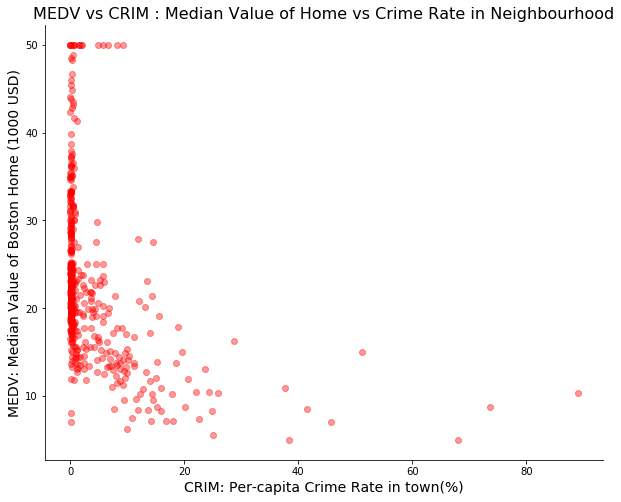

In [111]:
#Prepare the data
x=boston['CRIM'].values 
y=boston['MEDV'].values

#Prepare the plot
plt.figure(figsize=(10,8))
plt.title('MEDV vs CRIM : Median Value of Home vs Crime Rate in Neighbourhood', fontsize=16)
plt.xlabel('CRIM: Per-capita Crime Rate in town(%)', fontsize=14)
plt.ylabel('MEDV: Median Value of Boston Home (1000 USD)', fontsize=14)
plt.grid(False)

#Plot the data
plt.scatter(x,y, c='r', alpha = 0.4, label = 'Sample Observations')

#Remove axes and spline
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Plot Interpretation
We can see that the per-capita crime rate in most towns is really high. The towns with high median value of homes tend to have lower crime levels. The towns with low per-capita crime rate tend to have a high variability in median home values. Overall the trend is downward linear, with higher home values associated with lower crime rates.

We could possibly fit a linear regression line, but looking at the graph, we should expect the graph to not do well in portions of the data. E.g. there is high variance (in the lower crime neighborhoods).

#### Train & Test 

In [135]:
#Train and test 66% using OLS
X_train, X_test, y_train, y_test = train_test_split(X_df, boston['MEDV'], train_size=0.66, random_state=0)
boston_train, boston_test = X_train, X_test
boston_train['MEDV'], boston_test['MEDV'] = y_train, y_test

#### Linear Regression (MEDV vs RM)

In [136]:
all_cols = list(boston)
linear_model = smf.ols(formula="MEDV ~ RM", data=boston_train)
res = linear_model.fit()
print(res.params)

Intercept   -35.6203
RM            9.2633
dtype: float64


In [137]:
preds_test = res.predict(boston_test)
preds_train = res.predict(boston_train)

#### Evaluate RMSE (MEDV vs RM1)

In [138]:
train_rmse = np.sqrt(mean_squared_error(preds_train, y_train))
print('Train RMSE =', train_rmse)
test_rmse = np.sqrt(mean_squared_error(preds_test, y_test))
print('Test RMSE  =', test_rmse)

Train RMSE = 6.60572149527
Test RMSE  = 6.60169540079


Clearly the train and test RMSE are decent. The test RMSE is even lower than the Train Error, which is a plausible occurrence. It does not imply that we are underfitting or overfitting. 

### 4.2 So many scatterplots!

Choose 8 out of the of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

In [139]:
features = ['CRIM','CHAS', 'NOX', 'RM', 'AGE', 'DIS','PTRATIO','LSTAT']
print('All Features    : ', all_cols)
print('Chosen Features : ', features)

All Features    :  ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
Chosen Features :  ['CRIM', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'LSTAT']


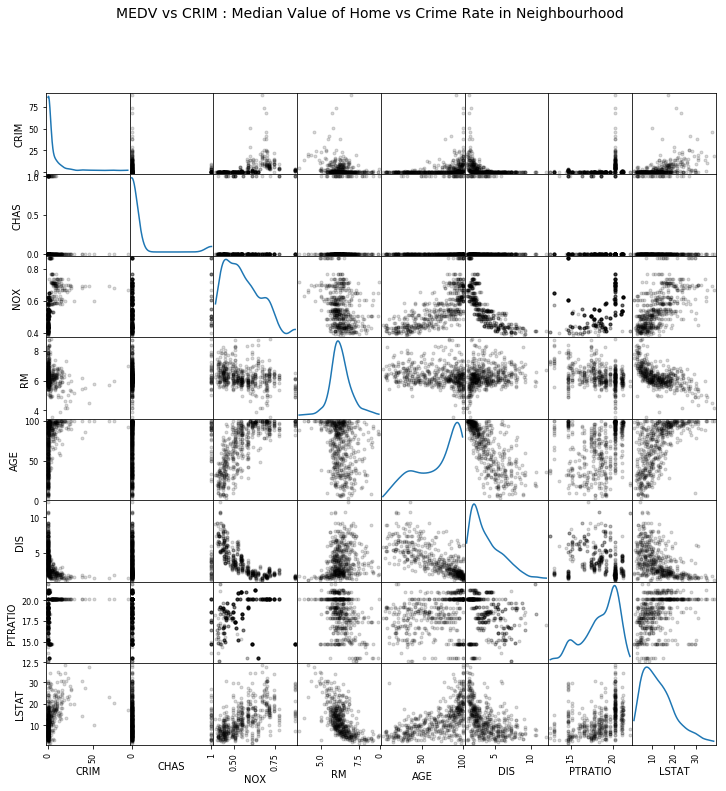

In [140]:
from pandas.tools.plotting import scatter_matrix

#Plot the data
scatter_matrix(boston[features], c= 'k', alpha=0.15, figsize=(12, 12), diagonal='kde')
plt.suptitle('MEDV vs CRIM : Median Value of Home vs Crime Rate in Neighbourhood', fontsize=14)

#### Plot Interpretation
This is an easy way to look at multiple histograms and scatter plots at once. 
We can quicly spot some correlations between some of our features. E.g. RM is a normal distribution, LSTAT is a skewed normal distribution, but RM vs LSTAT shows a strong pattern. 

Similarly, we can see other correlated pairs such as - NOX and AGE, AGE and DIS, AGE and LSTAT, NOX and LSTAT, DIS and NOX, PTRATIO and LSTAT etc.

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

#### Scaling the Data
PCA is sensitive to scaling, so standardization is very important, unless all features are already measured in the same units

In [141]:
#STANDARDIZE
scaler = StandardScaler().fit(X_df)
print(scaler)
print('\nScaler Means :\n',  scaler.mean_ )
print('\nScaler Scale :\n', scaler.scale_)                                 


StandardScaler(copy=True, with_mean=True, with_std=True)

Scaler Means :
 [  3.59376071e+00   1.13636364e+01   1.11367787e+01   6.91699605e-02
   5.54695059e-01   6.28463439e+00   6.85749012e+01   3.79504269e+00
   9.54940711e+00   4.08237154e+02   1.84555336e+01   3.56674032e+02
   1.26530632e+01   2.25328063e+01]

Scaler Scale :
 [  8.58828355e+00   2.32993957e+01   6.85357058e+00   2.53742935e-01
   1.15763115e-01   7.01922514e-01   2.81210326e+01   2.10362836e+00
   8.69865112e+00   1.68370495e+02   2.16280519e+00   9.12046075e+01
   7.13400164e+00   9.18801155e+00]


In [142]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)                             

#### Fit PCA

In [143]:
# Enter your code here
pca = PCA(n_components=12)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [144]:
#Individual PCA Component Explained Variance
variance= pca.explained_variance_ratio_
print(type(variance))
print(variance)

<class 'numpy.ndarray'>
[ 0.45972476  0.12285571  0.0951565   0.069266    0.05923376  0.04734517
  0.03956171  0.02816343  0.02078201  0.01744159  0.01471639  0.01233764]


In [145]:
#Find cumulative variance
cum_variance = np.cumsum(variance)
print(type(cum_variance))
print(cum_variance)

<class 'numpy.ndarray'>
[ 0.45972476  0.58258047  0.67773697  0.74700297  0.80623673  0.8535819
  0.89314361  0.92130704  0.94208905  0.95953064  0.97424703  0.98658467]


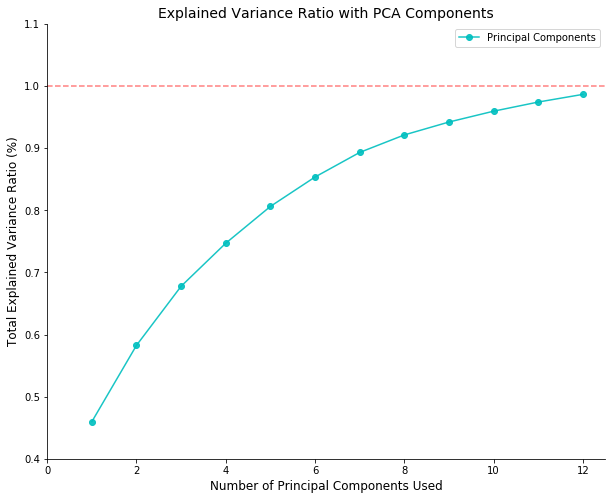

In [146]:
#Prepare the data
x=range(1,13)
y=cum_variance

#Prepare the plot
plt.figure(figsize=(10,8))
plt.title('Explained Variance Ratio with PCA Components', fontsize=14)
plt.xlabel('Number of Principal Components Used', fontsize=12)
plt.ylabel('Total Explained Variance Ratio (%)', fontsize=12)
plt.grid(False)

#Plot the data
plt.plot(x,y, c='c', marker='o', alpha = 0.9, label = 'Principal Components')
plt.axhline(y=1, color='r', alpha = 0.5, linestyle='--')
plt.legend(loc='best')

# set axes range
plt.xlim(0, 12.5)
plt.ylim(0.4, 1.1)

#Remove axes and spline
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Variance Plot Explained:
The 1st principal component out of 12 explains ~45% of the total variance of the data. After scaling, we can see that each new PC added to the model explains more variance until eventually all PC together explain all the variance in the Boston housing features.

We hope to be able to use these Principal Components instead of existing features.

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [66]:
Z_tr= pca.fit_transform(X_train_scaled)
print(type(Z_tr))
print(Z_tr[:3])

<class 'numpy.ndarray'>
[[  2.47760252e-01   3.00817931e+00  -1.30260687e+00   1.67807629e+00
    2.30075974e+00  -3.33655294e-01  -1.49303241e-01   7.86995884e-01
    6.13243846e-01  -2.38895926e-01  -5.97739259e-01  -7.78893325e-01]
 [  1.66082871e+00  -6.67687297e-01   1.05294078e+00   8.25727450e-01
   -6.75018865e-01  -3.19757805e-01  -1.18048022e+00   1.12884571e+00
   -3.58074685e-01  -7.09458023e-02   6.49343584e-01   5.18007686e-02]
 [  3.78368692e+00  -4.85922645e-02   8.37727531e-01   1.37353995e-01
   -3.76877433e-01   1.30130065e+00  -4.71305345e-04  -4.27575803e-01
   -1.28533616e-01  -3.20297526e-01   3.01909891e-01   7.51455221e-02]]


#### Plot PC1, PC2, Response (MEDV)

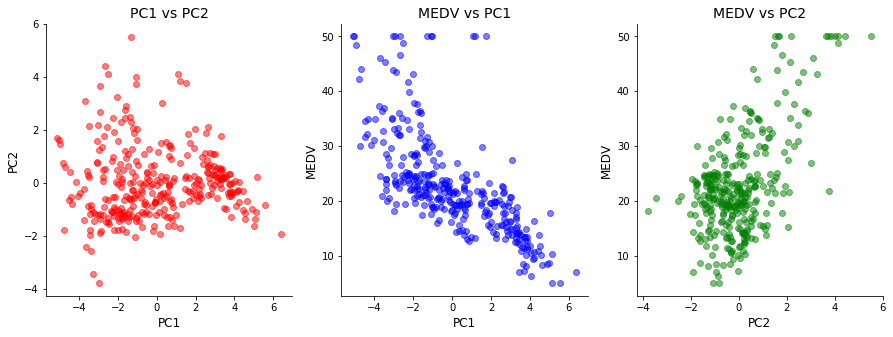

In [83]:
#Prepare the data
pca1 = Z_tr[:,0]     #all rows, 1st column
pca2 = Z_tr[:,1]     #all rows, 2nd column
medv = y_train.values  #MEDV

#Prepare the plot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.set_title('PC1 vs PC2', fontsize=14)
ax1.set_xlabel('PC1', fontsize=12)
ax1.set_ylabel('PC2', fontsize=12)

ax2.set_title('MEDV vs PC1', fontsize=14)
ax2.set_xlabel('PC1', fontsize=12)
ax2.set_ylabel('MEDV', fontsize=12)

ax3.set_title('MEDV vs PC2', fontsize=14)
ax3.set_xlabel('PC2', fontsize=12)
ax3.set_ylabel('MEDV', fontsize=12)

#Plot the data
ax1.scatter(pca1, pca2, c='r', alpha = 0.5, label = 'PC1 vs PC2')
ax2.scatter(pca1, medv, c='b', alpha = 0.5, label = 'MEDV vs PC1')
ax3.scatter(pca2, medv, c='g', alpha = 0.5, label = 'MEDV vs PC2')

#Remove axes and spline
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

#### Plot Interpretation
**Plot 1 : PC1 vs PC2**
This plot compares the new transformed axes. we can see that Principal Components are showing an arc like shape, with both PC1 and PC2 spreading our data points well across the entire plane with high variance along both PC1 and PC2 axis.

**Plot 2 : MEDV vs PC1**
PC1 seems to be a combination of all features that contribute to lower prices as the value of PC1 increases. E.g. CRIM, LSTAT, PTRATIO etc. could contribute heavily to such a relationship.

**Plot 3 : MEDV vs PC2**
PC2 seems to be a combination of features that had a positive correlation with MEDV. E.g. RM tends to positively increase with MEDV. 

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [68]:
#Scale, Apply PCA & Transform
Z_train = pca.fit_transform(X_train_scaled)  #Data already scaled
Z_test  = pca.transform(X_test_scaled) #No need to fit pca, already fit on train data

In [69]:
#Use only PC1
z1_train = Z_train[:,0]  #1st column 
z1_test  = Z_test[:,0]   #1st column

In [70]:
print(z1_train.shape)
print(z1_test.shape)

print(y_train.shape)
print(y_test.shape)

(333,)
(173,)
(333,)
(173,)


In [71]:
#To avoid value error in LinearRegression().fit()
#Reshape your data either using X.reshape(-1, 1) if it contains a single sample for X.
z1_train= z1_train.reshape(-1, 1)
z1_test = z1_test.reshape(-1, 1)

print(z1_train.shape)
print(z1_test.shape)

(333, 1)
(173, 1)


#### Principal Components Regression

In [72]:
from sklearn.linear_model import LinearRegression
target_col=['MEDV']
feature_list = ['PC1']

#Create LinearRegression object, fit the train data
lm= LinearRegression()
lm.fit(z1_train, y_train)
    
#Print findings. 
print('\nSKLearn Linear Regression\n-------------------------')
print('Model :', target_col, ' vs ', feature_list, '\n')
print('Number of Features               :' , len(feature_list))
print('Intercept Value                  :' , lm.intercept_)
print('Coefficient Values (No intercept):' , lm.coef_)


SKLearn Linear Regression
-------------------------
Model : ['MEDV']  vs  ['PC1'] 

Number of Features               : 1
Intercept Value                  : 22.8702702703
Coefficient Values (No intercept): [-2.5861062]


In [73]:
preds_train = lm.predict(z1_train)
preds_test  = lm.predict(z1_test)

#### RMSE (MEDV vs PC1)

In [74]:
train_rmse = np.sqrt(mean_squared_error(preds_train, y_train))
test_rmse = np.sqrt(mean_squared_error(preds_test, y_test))
print('Train RMSE =', train_rmse)
print('Test RMSE  =', test_rmse)

Train RMSE = 6.61223998353
Test RMSE  = 6.83297706214


#### Compare RMSE: PC Regression vs OLS Linear Regression
_Initial Model (With 1 features (RM))_
- Train RMSE = 6.606
- Test RMSE  = 6.602

_Principal Components Regression (With 1 Principal Component)_
- Train RMSE = 6.648
- Test RMSE  = 6.852


>With only 1 Pricipal component, as opposed to the previous feature of RM, we suffer a very small increase in RMSE for pretty similar and accurate results in this single trial. 

>However, this model is more generalizable as the Principal Components seem to show a good correlation with the MEDV(target) value.

> We are guaranteed that the Principal components are orthogonal to each other, and so we will not overestimate the effects of any single feature.

>In general, usink K Principal components ensures better performance than a model with any K original features.

#### Extra Plot : Can PC1 predict MEDV?

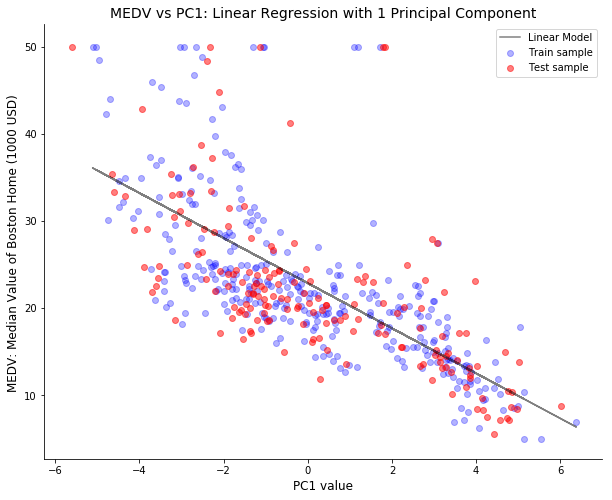

In [81]:
#Prepare the data
x1 = z1_train
y1 = y_train

x2 = z1_test
y2 = y_test

#Prepare the plot
plt.figure(figsize=(10,8))
plt.title('MEDV vs PC1: Linear Regression with 1 Principal Component', fontsize=14)
plt.xlabel('PC1 value', fontsize=12)
plt.ylabel('MEDV: Median Value of Boston Home (1000 USD) ', fontsize=12)
plt.grid(False)

#Plot the data
plt.scatter(x1,y1, c='b', marker='o', alpha = 0.3, label = 'Train sample')
plt.scatter(x2,y2, c='r', marker='o', alpha = 0.5, label = 'Test sample')
plt.plot(x1, preds_train, c='k', alpha=0.5, label = 'Linear Model')

plt.legend(loc='best')

#Remove axes and spline
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Plot Interpretation
As compared to the previous graph for MEDV vs RM, we can see a much stronger correlation between PC1 and the predicted MEDV.
This graph definitely has a higher R-squared value and would be more generalizable.

                  -----------------------------------------*THE END *-----------------------------------------

#### Useful Links 
Pipeline
- http://scikit-learn.org/stable/modules/pipeline.html
- http://scikit-learn.org/stable/modules/preprocessing.html

Grid Search
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://chrisalbon.com/machine-learning/cross_validation_parameter_tuning_grid_search.html

Cross Validation with Score
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

Evaluating Classifiers
- http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

Sklearn's   Log Loss /Cross-Entropy Loss
- http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
- This is defined as the negative log-likelihood of the true labels given a probabilistic classifier’s predictions.
- y_true = True label (0/1)
- y_pred = Predicted probabilities, as returned by a classifier’s predict_proba method
- For a single sample with true label yt in {0,1} and estimated probability yp that yt = 1, the log loss is
-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))